In [ ]:
import librosa
import numpy as np
import os
import pandas as pd

def audio_to_audio_frame_stack(sound_data, frame_length, hop_length_frame):
    """This function take an audio and split into several frame
       in a numpy matrix of size (nb_frame,frame_length)"""

    sequence_sample_length = sound_data.shape[0]

    sound_data_list = [sound_data[start:start + frame_length] for start in range(
    0, sequence_sample_length - frame_length + 1, hop_length_frame)]  # get sliding windows
    sound_data_array = np.vstack(sound_data_list)

    return sound_data_array


def audio_files_to_numpy(audio_dir, list_audio_files, sample_rate, frame_length, hop_length_frame, min_duration):
    """This function take audio files of a directory and merge them
    in a numpy matrix of size (nb_frame,frame_length) for a sliding window of size hop_length_frame"""

    list_sound_array = []

    for file in list_audio_files:
        # open the audio file
        y, sr = librosa.load(os.path.join(audio_dir, file), sr=sample_rate)
        total_duration = librosa.get_duration(y=y, sr=sr)

        if (total_duration >= min_duration):
            list_sound_array.append(audio_to_audio_frame_stack(
                y, frame_length, hop_length_frame))
        else:
            print(
                f"The following file {os.path.join(audio_dir,file)} is below the min duration")

    return np.vstack(list_sound_array)


def blend_noise_randomly(voice, noise, nb_samples, frame_length):
    """This function takes as input numpy arrays representing frames
    of voice sounds, noise sounds and the number of frames to be created
    and return numpy arrays with voice randomly blend with noise"""

    prod_voice = np.zeros((nb_samples, frame_length))
    prod_noise = np.zeros((nb_samples, frame_length))
    prod_noisy_voice = np.zeros((nb_samples, frame_length))

    for i in range(nb_samples):
        id_voice = np.random.randint(0, voice.shape[0])
        id_noise = np.random.randint(0, noise.shape[0])
        level_noise = np.random.uniform(0.2, 0.8)
        prod_voice[i, :] = voice[id_voice, :]
        prod_noise[i, :] = level_noise * noise[id_noise, :]
        prod_noisy_voice[i, :] = prod_voice[i, :] + prod_noise[i, :]

    return prod_voice, prod_noise, prod_noisy_voice


def audio_to_magnitude_db_and_phase(n_fft, hop_length_fft, audio):
    """This function takes an audio and convert into spectrogram,
       it returns the magnitude in dB and the phase"""

    stftaudio = librosa.stft(audio, n_fft=n_fft, hop_length=hop_length_fft)
    stftaudio_magnitude, stftaudio_phase = librosa.magphase(stftaudio)

    stftaudio_magnitude_db = librosa.amplitude_to_db(
        stftaudio_magnitude, ref=np.max)

    return stftaudio_magnitude_db, stftaudio_phase


def numpy_audio_to_matrix_spectrogram(numpy_audio, dim_square_spec, n_fft, hop_length_fft):
    """This function takes as input a numpy audi of size (nb_frame,frame_length), and return
    a numpy containing the matrix spectrogram for amplitude in dB and phase. It will have the size
    (nb_frame,dim_square_spec,dim_square_spec)"""

    nb_audio = numpy_audio.shape[0]

    m_mag_db = np.zeros((nb_audio, dim_square_spec, dim_square_spec))
    m_phase = np.zeros((nb_audio, dim_square_spec, dim_square_spec), dtype=complex)

    for i in range(nb_audio):
        m_mag_db[i, :, :], m_phase[i, :, :] = audio_to_magnitude_db_and_phase(
            n_fft, hop_length_fft, numpy_audio[i])

    return m_mag_db, m_phase


def magnitude_db_and_phase_to_audio(frame_length, hop_length_fft, stftaudio_magnitude_db, stftaudio_phase):
    """This functions reverts a spectrogram to an audio"""

    stftaudio_magnitude_rev = librosa.db_to_amplitude(stftaudio_magnitude_db, ref=1.0)

    # taking magnitude and phase of audio
    audio_reverse_stft = stftaudio_magnitude_rev * stftaudio_phase
    audio_reconstruct = librosa.core.istft(audio_reverse_stft, hop_length=hop_length_fft, length=frame_length)

    return audio_reconstruct

def matrix_spectrogram_to_numpy_audio(m_mag_db, m_phase, frame_length, hop_length_fft)  :
    """This functions reverts the matrix spectrograms to numpy audio"""

    list_audio = []

    nb_spec = m_mag_db.shape[0]

    for i in range(nb_spec):

        audio_reconstruct = magnitude_db_and_phase_to_audio(frame_length, hop_length_fft, m_mag_db[i], m_phase[i])
        list_audio.append(audio_reconstruct)

    return np.vstack(list_audio)

def scaled_in(matrix_spec):
    "global scaling apply to noisy voice spectrograms (scale between -1 and 1)"
    matrix_spec = (matrix_spec + 46)/50
    return matrix_spec

def scaled_ou(matrix_spec):
    "global scaling apply to noise models spectrograms (scale between -1 and 1)"
    matrix_spec = (matrix_spec -6 )/82
    return matrix_spec

def inv_scaled_in(matrix_spec):
    "inverse global scaling apply to noisy voices spectrograms"
    matrix_spec = matrix_spec * 50 - 46
    return matrix_spec

def inv_scaled_ou(matrix_spec):
    "inverse global scaling apply to noise models spectrograms"
    matrix_spec = matrix_spec * 82 + 6
    return matrix_spec

In [ ]:
import matplotlib.pyplot as plt
import librosa.display

def make_plot_spectrogram(stftaudio_magnitude_db,sample_rate, hop_length_fft) :
    """This function plots a spectrogram"""
    plt.figure(figsize=(12, 6))
    librosa.display.specshow(stftaudio_magnitude_db, x_axis='time', y_axis='linear',
                             sr=sample_rate, hop_length=hop_length_fft)
    plt.colorbar()
    title = 'hop_length={},  time_steps={},  fft_bins={}  (2D resulting shape: {})'
    plt.title(title.format(hop_length_fft,
                           stftaudio_magnitude_db.shape[1],
                           stftaudio_magnitude_db.shape[0],
                           stftaudio_magnitude_db.shape));
    return

def make_plot_phase(stft_phase,sample_rate,hop_length_fft) :
    """This function plots the phase in radian"""
    plt.figure(figsize=(12, 6))
    librosa.display.specshow(np.angle(stft_phase), x_axis='time', y_axis='linear',
                             sr=sample_rate, hop_length=hop_length_fft)
    plt.colorbar()
    title = 'hop_length={},  time_steps={},  fft_bins={}  (2D resulting shape: {})'
    plt.title(title.format(hop_length_fft,
                           stft_phase.shape[1],
                           stft_phase.shape[0],
                           stft_phase.shape));
    return

def make_plot_time_serie(audio,sample_rate):
    """This function plots the audio as a time serie"""
    plt.figure(figsize=(12, 6))
    #plt.ylim(-0.05, 0.05)
    plt.title('Audio')
    plt.ylabel('Amplitude')
    plt.xlabel('Time(s)')
    librosa.display.waveplot(audio, sr=sample_rate)
    return


def make_3plots_spec_voice_noise(stftvoicenoise_mag_db,stftnoise_mag_db,stftvoice_mag_db,sample_rate, hop_length_fft):
    """This function plots the spectrograms of noisy voice, noise and voice as a single plot """
    plt.figure(figsize=(8, 12))
    plt.subplot(3, 1, 1)
    plt.title('Spectrogram voice + noise')
    librosa.display.specshow(stftvoicenoise_mag_db, x_axis='time', y_axis='linear',sr=sample_rate, hop_length=hop_length_fft)
    plt.colorbar()
    plt.subplot(3, 1, 2)
    plt.title('Spectrogram predicted voice')
    librosa.display.specshow(stftnoise_mag_db, x_axis='time', y_axis='linear',sr=sample_rate, hop_length=hop_length_fft)
    plt.colorbar()
    plt.subplot(3, 1, 3)
    plt.title('Spectrogram true voice')
    librosa.display.specshow(stftvoice_mag_db, x_axis='time', y_axis='linear',sr=sample_rate, hop_length=hop_length_fft)
    plt.colorbar()
    plt.tight_layout()

    return


def make_3plots_phase_voice_noise(stftvoicenoise_phase,stftnoise_phase,stftvoice_phase,sample_rate, hop_length_fft):
    """This function plots the phase in radians of noisy voice, noise and voice as a single plot """
    plt.figure(figsize=(8, 12))
    plt.subplot(3, 1, 1)
    plt.title('Phase (radian) voice + noise')
    librosa.display.specshow(np.angle(stftvoicenoise_phase), x_axis='time', y_axis='linear',sr=sample_rate, hop_length=hop_length_fft)
    plt.colorbar()
    plt.subplot(3, 1, 2)
    plt.title('Phase (radian) predicted voice')
    librosa.display.specshow(np.angle(stftnoise_phase), x_axis='time', y_axis='linear',sr=sample_rate, hop_length=hop_length_fft)
    plt.colorbar()
    plt.subplot(3, 1, 3)
    plt.title('Phase (radian) true voice')
    librosa.display.specshow(np.angle(stftvoice_phase), x_axis='time', y_axis='linear',sr=sample_rate, hop_length=hop_length_fft)
    plt.colorbar()
    plt.tight_layout()

    return


def make_3plots_timeseries_voice_noise(clipvoicenoise,clipnoise,clipvoice, sample_rate) :
    """This function plots the time series of audio of noisy voice, noise and voice as a single plot """
    #y_ax_min = min(clipvoicenoise) - 0.15
    #y_ax_max = max(clipvoicenoise) + 0.15

    plt.figure(figsize=(18, 12))
    plt.subplots_adjust(hspace=0.35)
    plt.subplot(3, 1, 1)
    plt.title('Audio voice + noise')
    plt.ylabel('Amplitude')
    plt.xlabel('Time(s)')
    librosa.display.waveplot(clipvoicenoise, sr=sample_rate)
    plt.ylim(-0.05, 0.05)
    plt.subplot(3, 1, 2)
    plt.title('Audio predicted voice')
    plt.ylabel('Amplitude')
    plt.xlabel('Time(s)')
    librosa.display.waveplot(clipnoise, sr=sample_rate)
    plt.ylim(-0.05, 0.05)
    plt.subplot(3, 1, 3)
    plt.title('Audio true voice')
    plt.ylabel('Amplitude')
    plt.xlabel('Time(s)')
    librosa.display.waveplot(clipvoice, sr=sample_rate)
    plt.ylim(-0.05, 0.05)

    return

In [ ]:
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, LeakyReLU, MaxPooling2D, Dropout, concatenate, UpSampling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend
import tensorflow as tf
print(tf.__version__)

#Unet network
def unet(pretrained_weights = None,input_size = (128,128,1)):
    #size filter input
    size_filter_in = 16
    #normal initialization of weights
    kernel_init = 'he_normal'
    #To apply leaky relu after the conv layer 
    activation_layer = None
    inputs = Input(input_size)
    conv1 = Conv2D(size_filter_in, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(inputs)
    conv1 = LeakyReLU()(conv1)
    conv1 = Conv2D(size_filter_in, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(conv1)
    conv1 = LeakyReLU()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(size_filter_in*2, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(pool1)
    conv2 = LeakyReLU()(conv2)
    conv2 = Conv2D(size_filter_in*2, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(conv2)
    conv2 = LeakyReLU()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(size_filter_in*4, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(pool2)
    conv3 = LeakyReLU()(conv3)
    conv3 = Conv2D(size_filter_in*4, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(conv3)
    conv3 = LeakyReLU()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(size_filter_in*8, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(pool3)
    conv4 = LeakyReLU()(conv4)
    conv4 = Conv2D(size_filter_in*8, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(conv4)
    conv4 = LeakyReLU()(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(size_filter_in*16, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(pool4)
    conv5 = LeakyReLU()(conv5)
    conv5 = Conv2D(size_filter_in*16, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(conv5)
    conv5 = LeakyReLU()(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(size_filter_in*8, 2, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(UpSampling2D(size = (2,2))(drop5))
    up6 = LeakyReLU()(up6)
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(size_filter_in*8, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(merge6)
    conv6 = LeakyReLU()(conv6)
    conv6 = Conv2D(size_filter_in*8, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(conv6)
    conv6 = LeakyReLU()(conv6)
    up7 = Conv2D(size_filter_in*4, 2, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(UpSampling2D(size = (2,2))(conv6))
    up7 = LeakyReLU()(up7)
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(size_filter_in*4, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(merge7)
    conv7 = LeakyReLU()(conv7)
    conv7 = Conv2D(size_filter_in*4, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(conv7)
    conv7 = LeakyReLU()(conv7)
    up8 = Conv2D(size_filter_in*2, 2, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(UpSampling2D(size = (2,2))(conv7))
    up8 = LeakyReLU()(up8)
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(size_filter_in*2, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(merge8)
    conv8 = LeakyReLU()(conv8)
    conv8 = Conv2D(size_filter_in*2, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(conv8)
    conv8 = LeakyReLU()(conv8)

    up9 = Conv2D(size_filter_in, 2, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(UpSampling2D(size = (2,2))(conv8))
    up9 = LeakyReLU()(up9)
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(size_filter_in, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(merge9)
    conv9 = LeakyReLU()(conv9)
    conv9 = Conv2D(size_filter_in, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(conv9)
    conv9 = LeakyReLU()(conv9)
    conv9 = Conv2D(2, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(conv9)
    conv9 = LeakyReLU()(conv9)
    conv10 = Conv2D(1, 1, activation = 'tanh')(conv9)

    model = Model(inputs,conv10)
    model.compile(loss="binary_crossentropy", optimizer= "adam", metrics=['accuracy'])
    model.compile(optimizer = 'adam', loss = tf.keras.losses.Huber(), metrics = ['mae'])

    #model.summary()

    if(pretrained_weights):
    	model.load_weights(pretrained_weights)

    return model

2.7.0


In [ ]:
import librosa
import tensorflow as tf
from tensorflow.keras.models import model_from_json
import soundfile as sf

def prediction(weights_path, name_model, audio_dir_prediction, dir_save_prediction, audio_input_prediction,
audio_output_prediction, sample_rate, min_duration, frame_length, hop_length_frame, n_fft, hop_length_fft):
    """ This function takes as input pretrained weights, noisy voice sound to denoise, predict
    the denoise sound and save it to disk.
    """

    # load json and create model
    json_file = open(weights_path+'/'+name_model+'.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights(weights_path+'/'+name_model+'.h5')
    print("Loaded model from disk")

    # Extracting noise and voice from folder and convert to numpy
    audio = audio_files_to_numpy(audio_dir_prediction, audio_input_prediction, sample_rate,
                                 frame_length, hop_length_frame, min_duration)

    #Dimensions of squared spectrogram
    dim_square_spec = int(n_fft / 2) + 1
    print(dim_square_spec)

    # Create Amplitude and phase of the sounds
    m_amp_db_audio,  m_pha_audio = numpy_audio_to_matrix_spectrogram(
        audio, dim_square_spec, n_fft, hop_length_fft)

    #global scaling to have distribution -1/1
    X_in = scaled_in(m_amp_db_audio)
    #Reshape for prediction
    X_in = X_in.reshape(X_in.shape[0],X_in.shape[1],X_in.shape[2],1)
    #Prediction using loaded network
    X_pred = loaded_model.predict(X_in)
    #Rescale back the noise model
    inv_sca_X_pred = inv_scaled_ou(X_pred)
    #Remove noise model from noisy speech
    X_denoise = m_amp_db_audio - inv_sca_X_pred[:,:,:,0]
    #Reconstruct audio from denoised spectrogram and phase
    print(X_denoise.shape)
    print(m_pha_audio.shape)
    print(frame_length)
    print(hop_length_fft)
    audio_denoise_recons = matrix_spectrogram_to_numpy_audio(X_denoise, m_pha_audio, frame_length, hop_length_fft)
    #Number of frames
    nb_samples = audio_denoise_recons.shape[0]
    #Save all frames in one file
    denoise_long = audio_denoise_recons.reshape(1, nb_samples * frame_length)*10
    #librosa.output.write_wav(dir_save_prediction + audio_output_prediction, denoise_long[0, :], sample_rate)
    sf.write(dir_save_prediction + audio_output_prediction, denoise_long[0, :], sample_rate)
    
    #plt.imshow(X_pred[id,:,:,0])

In [ ]:
import os
import librosa
import numpy as np
import soundfile as sf


def create_data(noise_dir, voice_dir, path_save_time_serie, path_save_sound, path_save_spectrogram, sample_rate,
min_duration, frame_length, hop_length_frame, hop_length_frame_noise, nb_samples, n_fft, hop_length_fft):
    """This function will randomly blend some clean voices from voice_dir with some noises from noise_dir
    and save the spectrograms of noisy voice, noise and clean voices to disk as well as complex phase,
    time series and sounds. This aims at preparing datasets for denoising training. It takes as inputs
    parameters defined in args module"""

    list_noise_files = os.listdir(noise_dir)
    list_voice_files = os.listdir(voice_dir)

    def remove_ds_store(lst):
        """remove mac specific file if present"""
        if '.DS_Store' in lst:
            lst.remove('.DS_Store')

        return lst

    list_noise_files = remove_ds_store(list_noise_files)
    list_voice_files = remove_ds_store(list_voice_files)

    nb_voice_files = len(list_voice_files)
    nb_noise_files = len(list_noise_files)


    # Extracting noise and voice from folder and convert to numpy
    noise = audio_files_to_numpy(noise_dir, list_noise_files, sample_rate,
                                     frame_length, hop_length_frame_noise, min_duration)

    voice = audio_files_to_numpy(voice_dir, list_voice_files,
                                     sample_rate, frame_length, hop_length_frame, min_duration)

    # Blend some clean voices with random selected noises (and a random level of noise)
    prod_voice, prod_noise, prod_noisy_voice = blend_noise_randomly(
            voice, noise, nb_samples, frame_length)

    # To save the long audio generated to disk to QC:
    noisy_voice_long = prod_noisy_voice.reshape(1, nb_samples * frame_length)
    #librosa.output.write_wav(path_save_sound + 'noisy_voice_long.wav', noisy_voice_long[0, :], sample_rate)
    sf.write(path_save_sound + 'noisy_voice_long.wav', noisy_voice_long[0, :], sample_rate)
    voice_long = prod_voice.reshape(1, nb_samples * frame_length)
    #librosa.output.write_wav(path_save_sound + 'voice_long.wav', voice_long[0, :], sample_rate)
    sf.write(path_save_sound + 'voice_long.wav', voice_long[0, :], sample_rate)
    noise_long = prod_noise.reshape(1, nb_samples * frame_length)
    #librosa.output.write_wav(path_save_sound + 'noise_long.wav', noise_long[0, :], sample_rate)
    sf.write(path_save_sound + 'noise_long.wav', noise_long[0, :], sample_rate)
    # Squared spectrogram dimensions
    dim_square_spec = int(n_fft / 2) + 1

    # Create Amplitude and phase of the sounds
    m_amp_db_voice,  m_pha_voice = numpy_audio_to_matrix_spectrogram(
            prod_voice, dim_square_spec, n_fft, hop_length_fft)
    m_amp_db_noise,  m_pha_noise = numpy_audio_to_matrix_spectrogram(
            prod_noise, dim_square_spec, n_fft, hop_length_fft)
    m_amp_db_noisy_voice,  m_pha_noisy_voice = numpy_audio_to_matrix_spectrogram(
            prod_noisy_voice, dim_square_spec, n_fft, hop_length_fft)

    # Save to disk for Training / QC
    np.save(path_save_time_serie + 'voice_timeserie', prod_voice)
    np.save(path_save_time_serie + 'noise_timeserie', prod_noise)
    np.save(path_save_time_serie + 'noisy_voice_timeserie', prod_noisy_voice)


    np.save(path_save_spectrogram + 'voice_amp_db', m_amp_db_voice)
    np.save(path_save_spectrogram + 'noise_amp_db', m_amp_db_noise)
    np.save(path_save_spectrogram + 'noisy_voice_amp_db', m_amp_db_noisy_voice)

    np.save(path_save_spectrogram + 'voice_pha_db', m_pha_voice)
    np.save(path_save_spectrogram + 'noise_pha_db', m_pha_noise)
    np.save(path_save_spectrogram + 'noisy_voice_pha_db', m_pha_noisy_voice)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

def training(path_save_spectrogram, weights_path, name_model, training_from_scratch, epochs, batch_size):
    """ This function will read noisy voice and clean voice spectrograms created by data_creation mode,
    and train a Unet model on this dataset for epochs and batch_size specified. It saves best models to disk regularly
    If training_from_scratch is set to True it will train from scratch, if set to False, it will train
    from weights (name_model) provided in weights_path
    """
    #load noisy voice & clean voice spectrograms created by data_creation mode
    X_in = np.load(path_save_spectrogram +'noisy_voice_amp_db'+".npy")
    X_ou = np.load(path_save_spectrogram +'voice_amp_db'+".npy")
    #Model of noise to predict
    X_ou = X_in - X_ou

    #Check distribution
    print(stats.describe(X_in.reshape(-1,1)))
    print(stats.describe(X_ou.reshape(-1,1)))

    #to scale between -1 and 1
    X_in = scaled_in(X_in)
    X_ou = scaled_ou(X_ou)

    #Check shape of spectrograms
    print(X_in.shape)
    print(X_ou.shape)
    #Check new distribution
    print(stats.describe(X_in.reshape(-1,1)))
    print(stats.describe(X_ou.reshape(-1,1)))


    #Reshape for training
    X_in = X_in[:,:,:]
    X_in = X_in.reshape(X_in.shape[0],X_in.shape[1],X_in.shape[2],1)
    X_ou = X_ou[:,:,:]
    X_ou = X_ou.reshape(X_ou.shape[0],X_ou.shape[1],X_ou.shape[2],1)

    X_train, X_test, y_train, y_test = train_test_split(X_in, X_ou, test_size=0.10, random_state=42)

    #If training from scratch
    if training_from_scratch:

        generator_nn=unet()
    #If training from pre-trained weights
    else:

        generator_nn=unet(pretrained_weights = weights_path+name_model+'.h5')


    #Save best models to disk during training
    checkpoint = ModelCheckpoint(weights_path+'/model_best.h5', verbose=1, monitor='val_loss',save_best_only=True, mode='auto')
    
    generator_nn.summary()
    #Training
    history = generator_nn.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, shuffle=True, callbacks=[checkpoint], verbose=1, validation_data=(X_test, y_test))
    #generator_nn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    #Plot training and validation loss (log scale)
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)

    plt.plot(epochs, loss, label='Training loss')
    plt.plot(epochs, val_loss, label='Validation loss')
    plt.yscale('log')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()
    print(history)
    #print(generator_nn.metrics_names)
   
    


In [ ]:
import argparse

parser = argparse.ArgumentParser(description='Speech enhancement,data creation, training and prediction')

#mode to run the program (options: data creation, training or prediction)
parser.add_argument('--mode',default='training', type=str, choices=['data_creation', 'training', 'prediction'])
#folders where to find noise audios and clean voice audio to prepare training dataset (mode data_creation)
parser.add_argument('--noise_dir', default='/content/drive/MyDrive/ESC-50-master/audio/', type=str)

parser.add_argument('--voice_dir', default='/content/drive/MyDrive/LibriSpeech/dev-clean/1272/128104/', type=str)
#folders where to save spectrograms, time series and sounds for training / QC
parser.add_argument('--path_save_spectrogram', default='/content/drive/MyDrive/ESC-50-master/spectrogram/', type=str)

parser.add_argument('--path_save_time_serie', default='/content/drive/MyDrive/ESC-50-master/time_series/', type=str)

parser.add_argument('--path_save_sound', default='/content/drive/MyDrive/ESC-50-master/sound/', type=str)
#How much frame to create in data_creation mode
parser.add_argument('--nb_samples', default=50, type=int)
#Training from scratch or pre-trained weights
parser.add_argument('--training_from_scratch',default=True, type=bool)
#folder of saved weights
parser.add_argument('--weights_folder', default='/content/drive/MyDrive/weights', type=str)
#Nb of epochs for training
parser.add_argument('--epochs', default=10, type=int)
#Batch size for training
parser.add_argument('--batch_size', default=20, type=int)
#Name of saved model to read
parser.add_argument('--name_model', default='model_unet', type=str)
#directory where read noisy sound to denoise (prediction mode)
parser.add_argument('--audio_dir_prediction', default='/content/drive/MyDrive/demo_data/test', type=str)
#directory to save the denoise sound (prediction mode)
parser.add_argument('--dir_save_prediction', default='/content/drive/MyDrive/demo_data/save_predictions/', type=str)
#Noisy sound file to denoise (prediction mode)
parser.add_argument('--audio_input_prediction', default=['noisy_voice_long_t2.wav'], type=list)
#File name of sound output of denoise prediction
parser.add_argument('--audio_output_prediction', default='denoise_t2.wav', type=str)
# Sample rate chosen to read audio
parser.add_argument('--sample_rate', default=8000, type=int)
# Minimum duration of audio files to consider
parser.add_argument('--min_duration', default=1.0, type=float)
# Training data will be frame of slightly above 1 second
parser.add_argument('--frame_length', default=8064, type=int)
# hop length for clean voice files separation (no overlap)
parser.add_argument('--hop_length_frame', default=8064, type=int)
# hop length for noise files to blend (noise is splitted into several windows)
parser.add_argument('--hop_length_frame_noise', default=5000, type=int)
# Choosing n_fft and hop_length_fft to have squared spectrograms
parser.add_argument('--n_fft', default=255, type=int)

parser.add_argument('--hop_length_fft', default=63, type=int)
parser.add_argument('-f')

_StoreAction(option_strings=['-f'], dest='f', nargs=None, const=None, default=None, type=None, choices=None, help=None, metavar=None)

DescribeResult(nobs=819200, minmax=(array([-80.]), array([0.])), mean=array([-46.83084058]), variance=array([286.00731089]), skewness=array([0.01672061]), kurtosis=array([-0.43936124]))
DescribeResult(nobs=819200, minmax=(array([-48.36193408]), array([77.66370082])), mean=array([6.37229776]), variance=array([152.45648343]), skewness=array([1.71483176]), kurtosis=array([2.86616749]))
(50, 128, 128)
(50, 128, 128)
DescribeResult(nobs=819200, minmax=(array([-0.68]), array([0.92])), mean=array([-0.01661681]), variance=array([0.11440292]), skewness=array([0.01672061]), kurtosis=array([-0.43936124]))
DescribeResult(nobs=819200, minmax=(array([-0.66295042]), array([0.87394757])), mean=array([0.00454022]), variance=array([0.02267348]), skewness=array([1.71483176]), kurtosis=array([2.86616749]))
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to           

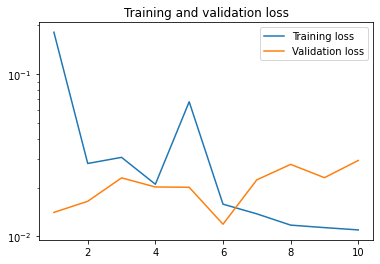

In [ ]:
import os

if __name__ == '__main__':

    args = parser.parse_args()

    mode = args.mode

    # Initialize all modes to zero
    data_mode = False
    training_mode = False
    prediction_mode = False

    # Update with the mode the user is asking
    if mode == 'prediction':
        prediction_mode = True
    elif mode == 'training':
        training_mode = True
    elif mode == 'data_creation':
        data_mode = True

    if data_mode:
        #Example: python main.py --mode='data_creation'

        #folder containing noises
        noise_dir = args.noise_dir
        #folder containing clean voices
        voice_dir = args.voice_dir
        #path to save time series
        path_save_time_serie = args.path_save_time_serie
        #path to save sounds
        path_save_sound = args.path_save_sound
        #path to save spectrograms
        path_save_spectrogram = args.path_save_spectrogram
        # Sample rate to read audio
        sample_rate = args.sample_rate
        # Minimum duration of audio files to consider
        min_duration = args.min_duration
        #Frame length for training data
        frame_length = args.frame_length
        # hop length for clean voice files
        hop_length_frame = args.hop_length_frame
        # hop length for noise files
        hop_length_frame_noise = args.hop_length_frame_noise
        # How much frame to create for training
        nb_samples = args.nb_samples
        #nb of points for fft(for spectrogram computation)
        n_fft = args.n_fft
        #hop length for fft
        hop_length_fft = args.hop_length_fft

        create_data(noise_dir, voice_dir, path_save_time_serie, path_save_sound, path_save_spectrogram, sample_rate,
        min_duration, frame_length, hop_length_frame, hop_length_frame_noise, nb_samples, n_fft, hop_length_fft)


    elif training_mode:
        #Example: python main.py --mode="training"
        #Path were to read spectrograms of noisy voice and clean voice
        path_save_spectrogram = args.path_save_spectrogram
        #path to find pre-trained weights / save models
        weights_path = args.weights_folder
        #pre trained model
        name_model = args.name_model
        #Training from scratch vs training from pre-trained weights
        training_from_scratch = args.training_from_scratch
        #epochs for training
        epochs = args.epochs
        #batch size for training
        batch_size = args.batch_size

        training(path_save_spectrogram, weights_path, name_model, training_from_scratch, epochs, batch_size)

    elif prediction_mode:
        #Example: python main.py --mode="prediction"
        #path to find pre-trained weights / save models
        weights_path = args.weights_folder
        #pre trained model
        name_model = args.name_model
        #directory where read noisy sound to denoise
        audio_dir_prediction = args.audio_dir_prediction
        #directory to save the denoise sound
        dir_save_prediction = args.dir_save_prediction
        #Name noisy sound file to denoise
        audio_input_prediction = args.audio_input_prediction
        #Name of denoised sound file to save
        audio_output_prediction = args.audio_output_prediction
        # Sample rate to read audio
        sample_rate = args.sample_rate
        # Minimum duration of audio files to consider
        min_duration = args.min_duration
        #Frame length for training data
        frame_length = args.frame_length
        # hop length for sound files
        hop_length_frame = args.hop_length_frame
        #nb of points for fft(for spectrogram computation)
        n_fft = args.n_fft
        #hop length for fft
        hop_length_fft = args.hop_length_fft

        prediction(weights_path, name_model, audio_dir_prediction, dir_save_prediction, audio_input_prediction,
        audio_output_prediction, sample_rate, min_duration, frame_length, hop_length_frame, n_fft, hop_length_fft)

In [ ]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
sys.path.append('..')
import librosa
import tensorflow as tf
from tensorflow.keras.models import model_from_json

path_weights = '/content/drive/MyDrive/weights/'

# load json and create model
json_file = open(path_weights+'model_unet.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights(path_weights+'model_unet.h5')
print("Loaded model from disk")

audio_dir_prediction = '/content/drive/MyDrive/demo_data/test'
audio_input_prediction = ['noisy_voice_long_t2.wav']

# Sample rate chosen to read audio
sample_rate = 8000

# Minimum duration of audio files to consider
min_duration = 1.0

# Our training data will be frame of slightly above 1 second
frame_length = 8064

# hop length for clean voice files separation (no overlap)
hop_length_frame = 8064

# hop length for noise files (we split noise into several windows)
hop_length_frame_noise = 5000


# Extracting noise and voice from folder and convert to numpy
audio = audio_files_to_numpy(audio_dir_prediction, audio_input_prediction, sample_rate,
                             frame_length, hop_length_frame, min_duration)

# Choosing n_fft and hop_length_fft to have squared spectrograms
n_fft = 255
hop_length_fft = 63

dim_square_spec = int(n_fft / 2) + 1

# Create Amplitude and phase of the sounds
m_amp_db_audio,  m_pha_audio = numpy_audio_to_matrix_spectrogram(
    audio, dim_square_spec, n_fft, hop_length_fft)

#global scaling to have distribution -1/1
X_in = scaled_in(m_amp_db_audio)
#Reshape for prediction
X_in = X_in.reshape(X_in.shape[0],X_in.shape[1],X_in.shape[2],1)
#Prediction using loaded network
X_pred = loaded_model.predict(X_in)
#Rescale back the noise model
inv_sca_X_pred = inv_scaled_ou(X_pred)
#Remove noise model from noisy speech
X_denoise = m_amp_db_audio - inv_sca_X_pred[:,:,:,0]
#Reconstruct audio from denoised spectrogram and phase
audio_denoise_recons = matrix_spectrogram_to_numpy_audio(X_denoise, m_pha_audio, frame_length, hop_length_fft)
#Number of frames
nb_samples = audio_denoise_recons.shape[0]

def test_dimensions_spectrogram():
    """ test that dimensions are correct"""
    assert dim_square_spec == 128
    assert dim_square_spec == m_amp_db_audio.shape[1]
    assert dim_square_spec == m_amp_db_audio.shape[2]
    assert dim_square_spec == X_denoise.shape[1]
    assert dim_square_spec == X_denoise.shape[2]
    assert nb_samples == 5

Loaded model from disk


-----------------------DEMO----------------------------------

In [ ]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
sys.path.append('..')
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import IPython.display as ipd

# Sample rate chosen to read audio
sample_rate = 8000

# Minimum duration of audio files to consider
min_duration = 1.0

# Our training data will be frame of slightly above 1 second
frame_length = 8064

# hop length for clean voice files separation (no overlap)
hop_length_frame = 8064

# Choosing n_fft and hop_length_fft to have squared spectrograms
n_fft = 255
hop_length_fft = 63

dim_square_spec = int(n_fft / 2) + 1


validation_folder_ex = '/content/drive/MyDrive/demo_data/validation'


In [ ]:
list_files = ['noisy_voice_bells28.wav','voice_pred_bells28.wav','voice_bells28.wav']

In [ ]:
noisy_voice_bells, sr = librosa.load(os.path.join(validation_folder_ex,list_files[0]), sr=sample_rate)
ipd.Audio(noisy_voice_bells, rate=8000)

In [ ]:
voice_pred_bells, sr = librosa.load(os.path.join(validation_folder_ex,list_files[1]), sr=sample_rate)
ipd.Audio(voice_pred_bells, rate=8000)

In [ ]:
voice_bells, sr = librosa.load(os.path.join(validation_folder_ex,list_files[2]), sr=sample_rate)
ipd.Audio(voice_bells, rate=8000)

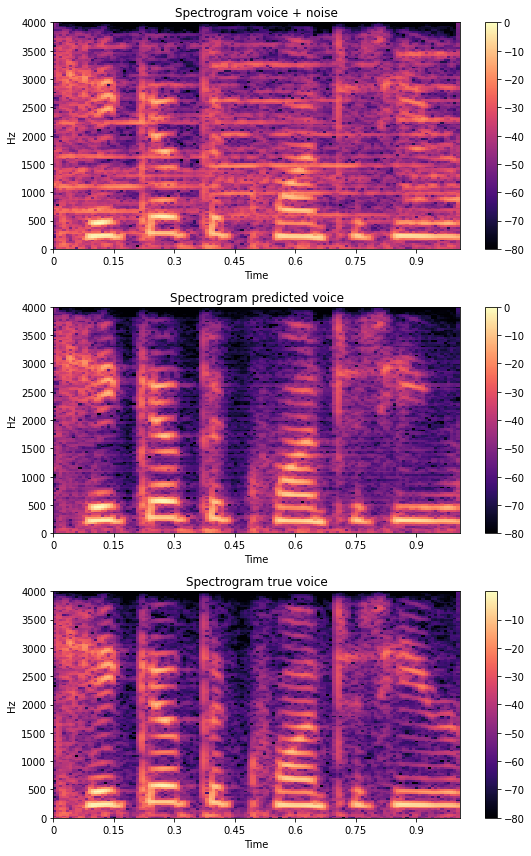

In [ ]:
m_amp_db_noisy_voice,  m_pha_noisy_voice =  numpy_audio_to_matrix_spectrogram (noisy_voice_bells.reshape(1,8064), dim_square_spec, n_fft, hop_length_fft)

m_amp_db_voice_pred,  m_pha_voice_pred =  numpy_audio_to_matrix_spectrogram (voice_pred_bells.reshape(1,8064), dim_square_spec, n_fft, hop_length_fft)

m_amp_db_voice_true,  m_pha_voice_true =  numpy_audio_to_matrix_spectrogram (voice_bells.reshape(1,8064), dim_square_spec, n_fft, hop_length_fft)

make_3plots_spec_voice_noise(m_amp_db_noisy_voice[0,:,:],m_amp_db_voice_pred[0,:,:],m_amp_db_voice_true[0,:,:],sample_rate, hop_length_fft)

In [ ]:
m_amp_db_voice_true.shape

(1, 128, 128)

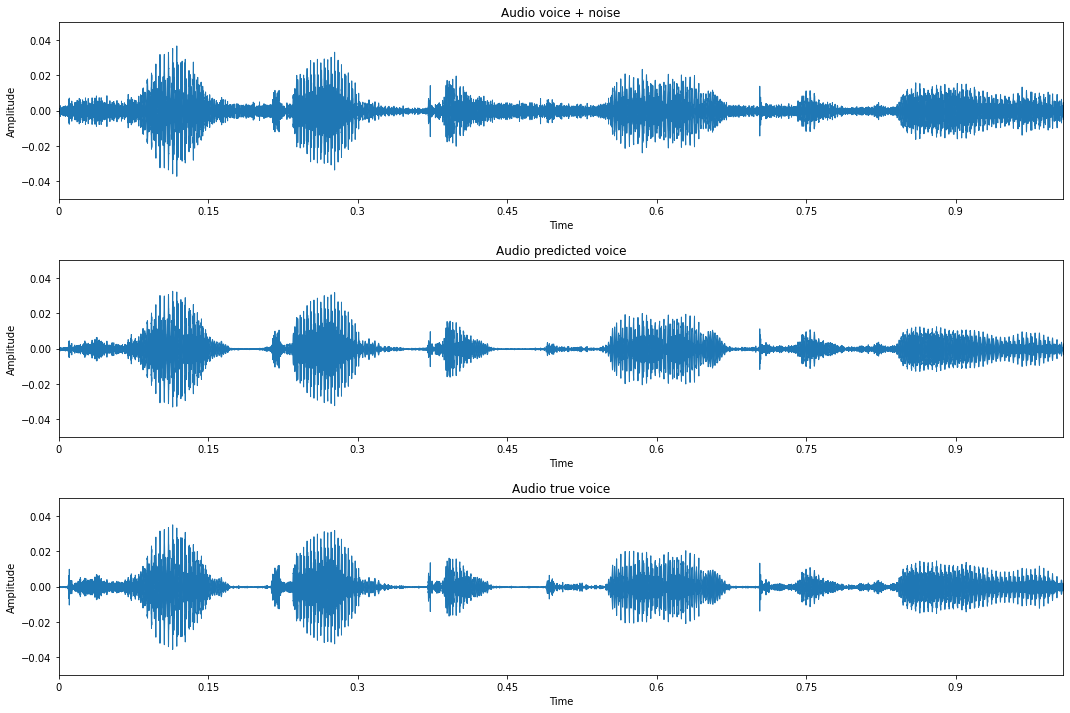

In [ ]:
make_3plots_timeseries_voice_noise(noisy_voice_bells,voice_pred_bells,voice_bells, sample_rate)

In [ ]:
import numpy as np

data = np.random.normal(0, 1, 100)
np.save('/content/drive/MyDrive/ESC-50-master/spectrogram/noise_amp_db.npy', data)

In [ ]:
import numpy as np
data = np.load('/content/drive/MyDrive/ESC-50-master/spectrogram/noise_amp_db.npy')
data

array([-6.86153409e-01,  8.19265975e-01,  2.85669790e-01, -1.40017930e+00,
        1.35571181e+00, -9.49885847e-01,  9.15323568e-01,  2.48379161e-01,
       -1.65844134e+00,  1.38884605e+00,  2.58521484e-01,  8.53255657e-01,
        1.96298456e+00, -7.95334707e-01,  2.11074385e+00, -2.21600399e-01,
       -8.71078820e-01, -1.40505658e+00,  1.03043187e+00,  3.14609166e-01,
       -2.91192905e-01, -8.40716622e-01,  5.30138089e-02,  7.46487999e-01,
       -2.73265080e-01, -7.81221933e-01,  1.39900421e+00, -4.93996038e-02,
       -6.38884372e-01, -1.44500140e+00,  1.14388772e+00, -1.38380403e+00,
        1.59894602e+00, -6.58582915e-01, -7.38997231e-01,  9.99483555e-02,
        1.45175511e+00,  1.26371706e+00, -7.26954470e-01,  1.74621433e+00,
       -7.55144488e-01, -6.45331709e-01,  6.44587839e-01,  1.50193941e+00,
       -2.25671401e+00, -1.03340200e+00,  1.01043401e+00, -4.48532211e-01,
        3.52697270e-02,  2.49817529e-01,  1.72277624e-01,  4.21943365e-02,
        6.62548414e-01,  

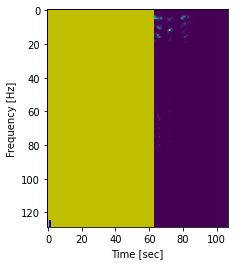

[0.016 0.044 0.072 0.1   0.128 0.156 0.184 0.212 0.24  0.268 0.296 0.324
 0.352 0.38  0.408 0.436 0.464 0.492 0.52  0.548 0.576 0.604 0.632 0.66
 0.688 0.716 0.744 0.772 0.8   0.828 0.856 0.884 0.912 0.94  0.968 0.996
 1.024 1.052 1.08  1.108 1.136 1.164 1.192 1.22  1.248 1.276 1.304 1.332
 1.36  1.388 1.416 1.444 1.472 1.5   1.528 1.556 1.584 1.612 1.64  1.668
 1.696 1.724 1.752 1.78  1.808 1.836 1.864 1.892 1.92  1.948 1.976 2.004
 2.032 2.06  2.088 2.116 2.144 2.172 2.2   2.228 2.256 2.284 2.312 2.34
 2.368 2.396 2.424 2.452 2.48  2.508 2.536 2.564 2.592 2.62  2.648 2.676
 2.704 2.732 2.76  2.788 2.816 2.844 2.872 2.9   2.928 2.956 2.984]


In [ ]:
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile
from matplotlib import colors as c

sample_rate, samples = wavfile.read('/content/drive/MyDrive/demo_data/save_predictions/denoise_t1.wav')
frequencies, times, spectrogram = signal.spectrogram(samples, sample_rate)
cMap = c.ListedColormap(['y','b','m'])
plt.pcolormesh(1/times, frequencies, spectrogram,cmap =cMap)
plt.imshow(spectrogram)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()
print(times)

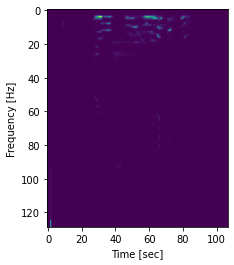

In [ ]:
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile

sample_rate, samples = wavfile.read('/content/drive/MyDrive/demo_data/test/noisy_voice_long_t1.wav')
frequencies, times, spectrogram = signal.spectrogram(samples, sample_rate)

plt.pcolormesh(times, frequencies, spectrogram)
plt.imshow(spectrogram)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

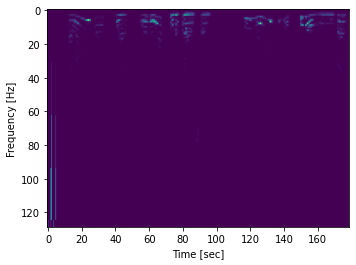

In [ ]:
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile

sample_rate, samples = wavfile.read('/content/drive/MyDrive/demo_data/save_predictions/denoise_t2.wav')
frequencies, times, spectrogram = signal.spectrogram(samples, sample_rate)

plt.pcolormesh(times, frequencies, spectrogram)
plt.imshow(spectrogram)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

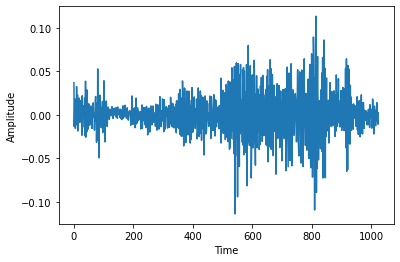

In [ ]:
import scipy
from scipy.io.wavfile import read
import matplotlib.pyplot as plt
# Read the .wav file
input_data = read("/content/drive/MyDrive/demo_data/test/noisy_voice_long_t2.wav")
audio = input_data[1]
plt.plot(audio[0:1024])
plt.ylabel("Amplitude")
plt.xlabel("Time")
plt.show()

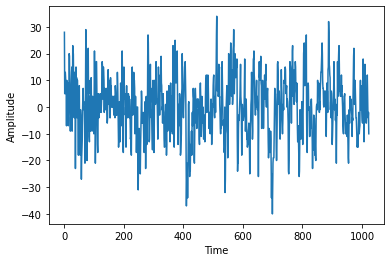

In [ ]:
import scipy
from scipy.io.wavfile import read
import matplotlib.pyplot as plt
# Read the .wav file
input_data = read("/content/drive/MyDrive/demo_data/save_predictions/denoise_t2.wav")
audio = input_data[1]
plt.plot(audio[0:1024])
plt.ylabel("Amplitude")
plt.xlabel("Time")
plt.show()

TypeError: ignored

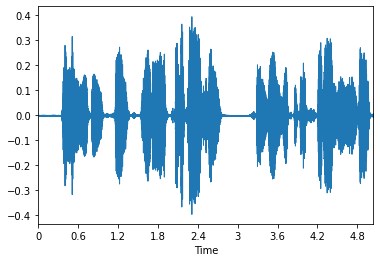

In [ ]:
import librosa
import librosa.display

y, sr = librosa.load('/content/drive/MyDrive/demo_data/save_predictions/denoise_t2.wav', sr=8000)
fig, ax = librosa.display.waveplot(y, sr=sr)

TypeError: ignored

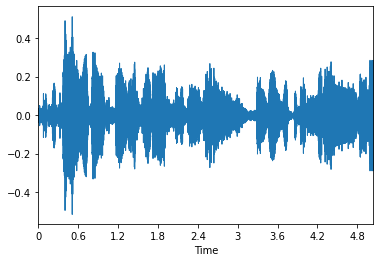

In [ ]:
import librosa
import librosa.display

y, sr = librosa.load('/content/drive/MyDrive/demo_data/test/noisy_voice_long_t2.wav', sr=8000)
fig, ax = librosa.display.waveplot(y, sr=sr)